# Detailed Steps Example

#### This notebook demonstrates data cleaning, peak fitting and descriptors generation step by step, serving as a detailed example of the `process_data_example.ipynb`.

### Packages and Needed Files Preparation

#### First, we import the packates we need:

In [1]:
import sys
sys.path.append("../data-science-appraoches-for-tdcp-analysis")
import chachifuncs as ccf
import databasefuncs as dbfs
import databasewrappers_forjupyter as dbfj
import itertools
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sqlite3 as sql

%matplotlib inline

#### And we use an example database and raw data to demonstrate.

In [2]:
database = 'MyExampleDatabase.db'
path = 'CS2_33_10_04_10.xlsx'
datatype = 'CALCE'
username = 'Mary Poppins'

# the below is to get the variable filename
filename = path
while '/' in filename:
    filename = filename.split('/', maxsplit = 1)[1]

### Data Cleaning

#### Then, we take a look at the cycle 1 of raw data 

All data separated into cycles and saved in database.


(-7, 7)

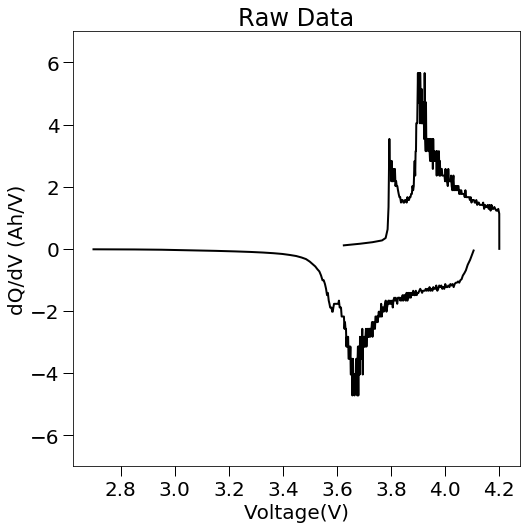

In [3]:
raw_df = ccf.load_sep_cycles(path, database, datatype)

fig1 = plt.figure(figsize = (8,8), facecolor = 'w', edgecolor= 'k')

# create the color map based off of the max value in the cycle index column
colors = matplotlib.cm.Greys(np.linspace(0.3, 1, int(max(raw_df[20]['Cycle_Index']))))

plt.plot(raw_df[1]['Voltage(V)'], raw_df[1]['dQ/dV'], c = 'black', linewidth = 2, label = 'Raw Cycle Data') 

plt.ylabel('dQ/dV (Ah/V)', fontsize =20)
plt.xlabel('Voltage(V)', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(size = 10, width = 1)
plt.title('Raw Data', fontsize = 24)

# plt.xlim(0, 4)
plt.ylim(-7,7)

# Uncomment the following line if you would like to save the plot. 
# plt.savefig(fname = 'MyExampleCycle.png', bbox_inches='tight', dpi = 600)

#### Excute fuction `drop_0_dv` to drop rows where dV=0 (or about 0) in a dataframe that has already had dv calculated, then recalculates dV and calculates dQ/dV.

(-7, 7)

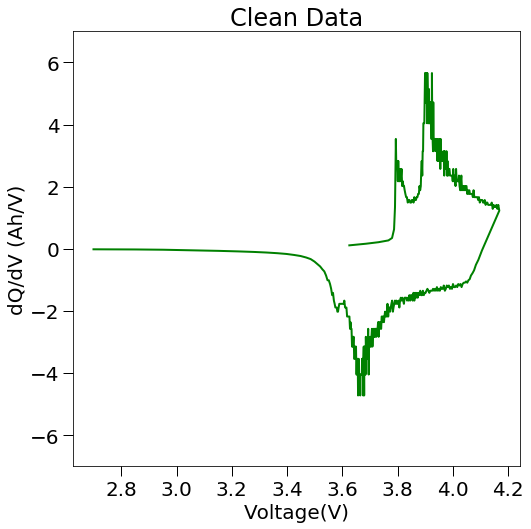

In [4]:
thresh1 = 4.17
thresh2 = 4.25

clean_df = ccf.drop_0_dv(raw_df[1], thresh1, thresh2, datatype)

fig2 = plt.figure(figsize = (8,8), facecolor = 'w', edgecolor= 'k')

# create the color map based off of the max value in the cycle index column
colors = matplotlib.cm.Greys(np.linspace(0.3, 1, int(max(clean_df['Cycle_Index']))))

plt.plot(clean_df['Voltage(V)'], clean_df['dQ/dV'], c = 'green', linewidth = 2, label = 'Clean Cycle Data') 

# plt.legend()
# leg = plt.legend(loc = 'upper right', fontsize = 14)
plt.ylabel('dQ/dV (Ah/V)', fontsize =20)
plt.xlabel('Voltage(V)', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(size = 10, width = 1)
plt.title('Clean Data', fontsize = 24)

# plt.xlim(0, 4)
plt.ylim(-7,7)

# Uncomment the following line if you would like to save the plot. 
# plt.savefig(fname = 'MyExampleCycle.png', bbox_inches='tight', dpi = 600)

#### Then, sperate cycles into charge and discharge cycles, and apply the Savitzky–Golay filter to smooth the data:

(-7, 7)

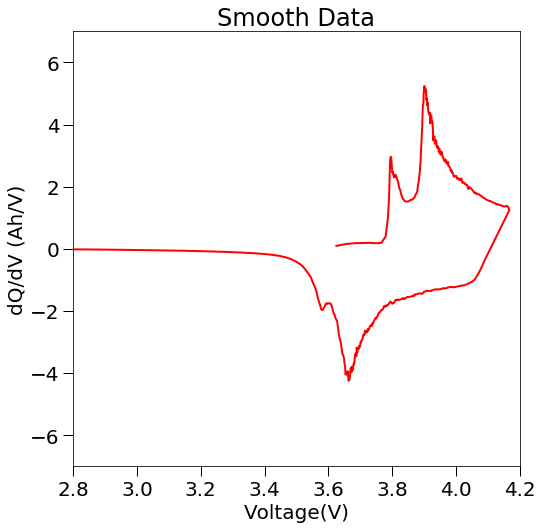

In [5]:
# separating into charge and discharge cycles
charge, discharge = ccf.sep_char_dis(clean_df, datatype)

windowlength = 9
polyorder = 3

# apply Savitzky–Golay filter
if len(discharge) > windowlength:
    smooth_discharge = ccf.my_savgolay(discharge, windowlength, polyorder)
else:
    discharge['Smoothed_dQ/dV'] = discharge['dQ/dV']
    smooth_discharge = discharge
# this if statement is for when the datasets have less datapoints
# than the windowlength given to the sav_golay filter.
# without this if statement, the sav_golay filter throws an error
# when given a dataset with too few points. This way, we simply
# forego the smoothing function.
if len(charge) > windowlength:
    smooth_charge = ccf.my_savgolay(charge, windowlength, polyorder)
else:
    charge['Smoothed_dQ/dV'] = charge['dQ/dV']
    smooth_charge = charge
# same as above, but for charging cycles.

# combine charge and discharge cycle data
smooth_df = charge.append(discharge, ignore_index=True)

fig3 = plt.figure(figsize = (8,8), facecolor = 'w', edgecolor= 'k')
# create the color map based off of the max value in the cycle index column
colors = matplotlib.cm.Greys(np.linspace(0.3, 1, int(max(smooth_df['Cycle_Index']))))

plt.plot(smooth_df['Voltage(V)'], smooth_df['Smoothed_dQ/dV'], c = 'red', linewidth = 2, label = 'Smooth Cycle Data') 

#plt.legend()
#leg = plt.legend(loc = 'upper right', fontsize = 14)
plt.ylabel('dQ/dV (Ah/V)', fontsize =20)
plt.xlabel('Voltage(V)', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(size = 10, width = 1)
plt.title('Smooth Data', fontsize = 24)

plt.xlim(2.8, 4.2)
plt.ylim(-7,7)

# Uncomment the following line if you would like to save the plot. 
# plt.savefig(fname = 'MyExampleCycle.png', bbox_inches='tight', dpi = 600)

### Peak Fitting

#### In this section, `lmfit` is the open-source fitting platform using a Levenberg-Marquart algorithm with numerically calculated derivatives. In this analysis, a mixture of Pseudo-Voigt distributions with a 4th degree polynomial background is fitted to the peak. 

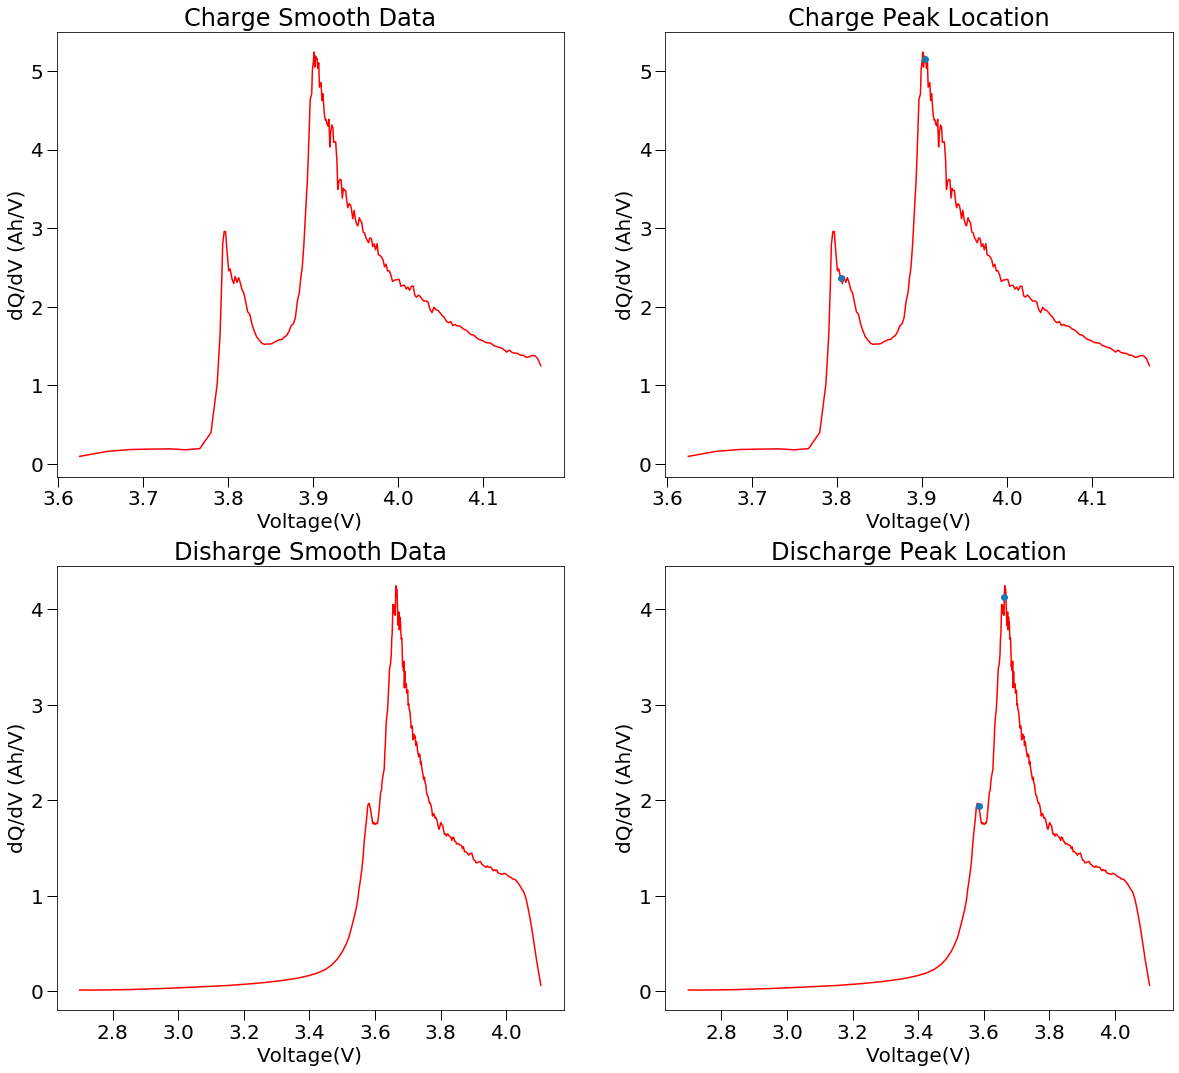

In [6]:
import peakutils
import scipy.signal

# separates charge and discharge cycles using chachifuncs
charge, discharge = ccf.sep_char_dis(smooth_df, datatype)

# takes out x and y-axis
sigx_bot1 = charge['Voltage(V)']
sigy_bot1 = (charge['Smoothed_dQ/dV'])
sigx_bot2 = discharge['Voltage(V)']
sigy_bot2 = -(discharge['Smoothed_dQ/dV'])

# set up a figure
fig4 = plt.figure(figsize = (20,18), facecolor = 'w', edgecolor= 'k')

plt.subplot(2, 2, 1)
plt.rcParams.update({'font.size':20})
plt.plot(sigx_bot1, sigy_bot1, 'r')
plt.xlabel('Voltage(V)', fontsize = 20)
plt.ylabel('dQ/dV (Ah/V)', fontsize =20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(size = 10, width = 1)
plt.title('Charge Smooth Data', fontsize = 24)

# applies additional level of smoothing to prevent indexing of false peaks
sigy_smooth1 = scipy.signal.savgol_filter(sigy_bot1, 25, 3)

# determines indexes of peaks in the dataset
i1 = peakutils.indexes(sigy_smooth1, thres=.3/max(sigy_bot1), min_dist=9)

plt.subplot(2, 2, 2)
plt.rcParams.update({'font.size':20})
plt.plot(sigx_bot1, sigy_bot1, 'r')
plt.xlabel('Voltage(V)', fontsize = 20)
plt.ylabel('dQ/dV (Ah/V)', fontsize =20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(size = 10, width = 1)
plt.title('Charge Peak Location', fontsize = 24)
plt.plot(sigx_bot1[i1], sigy_bot1[i1], 'o')

plt.subplot(2, 2, 3)
plt.rcParams.update({'font.size':20})
plt.plot(sigx_bot2, sigy_bot2, 'r')
plt.xlabel('Voltage(V)', fontsize = 20)
plt.ylabel('dQ/dV (Ah/V)', fontsize =20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(size = 10, width = 1)
plt.title('Disharge Smooth Data', fontsize = 24)

# applies additional level of smoothing to prevent indexing of false peaks
sigy_smooth2 = scipy.signal.savgol_filter(sigy_bot2, 25, 3)

# determines indexes of peaks in the dataset
i2 = peakutils.indexes(sigy_smooth2, thres=.3/max(sigy_bot2), min_dist=9)

plt.subplot(2, 2, 4)
plt.rcParams.update({'font.size':20})
plt.plot(sigx_bot2, sigy_bot2, 'r')
plt.xlabel('Voltage(V)', fontsize = 20)
plt.ylabel('dQ/dV (Ah/V)', fontsize =20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(size = 10, width = 1)
plt.title('Discharge Peak Location', fontsize = 24)
plt.plot(sigx_bot2[i2], sigy_bot2[i2], 'o')

#### `lmfit` model generation: The following cell creates model objects for use in the final fitting of the dQ/dV curve.

In [7]:
from lmfit import models

# creates a polynomial fitting object
mod = models.PolynomialModel(4)

# sets polynomial parameters based on a
# guess of a polynomial fit to the data with no peaks
par = mod.guess(sigy_bot2, x=sigx_bot2)

# iterates over all peak indices
for index in i2:
    
    # generates unique parameter strings based on index of peak
    pref = str(int(index))
    comb = 'a' + pref + '_'
    
    cent = 'center'
    sig = 'sigma'
    amp = 'amplitude'
    fract = 'fraction'
    
    # generates a pseudo voigt fitting model
    gaus_loop = models.PseudoVoigtModel(prefix = comb)
    par.update(gaus_loop.make_params())
    
    # uses unique parameter strings to generate parameters with initial guesses
    # in this model, the center of the peak is locked at the peak location determined from PeakUtils
    par[comb+cent].set(sigx_bot2[index], vary = False)
    
    # the other initial parameters were found by trial and error
    par[comb+sig].set(0.01)
    par[comb+amp].set(.05, min = 0)
    par[comb+fract].set(.5)
    
    # adds each pseudo voigt model to the polynomial model
    mod = mod + gaus_loop

#### Final fit generation: The following code uses the` mod` and `par` objects found above to determine the final fit to the battery cycle. The execution of this model is performed below:

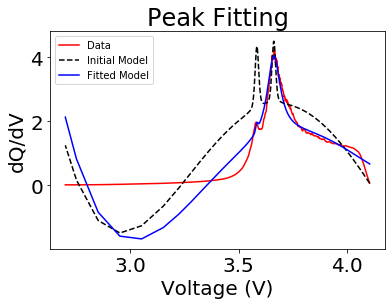

In [8]:
# evaluates fit using the default scipy.leastsquare method
model = mod.fit(sigy_bot2, par, x=sigx_bot2)

# generates a fit report containing fit parameters as well as error values
# print(model.fit_report(min_correl=0.5))

# plots data
plt.plot(sigx_bot2, sigy_bot2, 'r')
plt.plot(sigx_bot2, model.init_fit, 'k--')
plt.plot(sigx_bot2, model.best_fit, 'b-')
plt.xlabel('Voltage (V)')
plt.ylabel('dQ/dV')
plt.rcParams.update({'font.size':20})
plt.title('Peak Fitting', fontsize = 24)
plt.legend(['Data', 'Initial Model', 'Fitted Model'], loc=2, fontsize=10)

### Descriptor Generation

#### Dictionary Organization: Once the model is finished, the generated model is processed into a dictionary of descriptors. Here is an example of code:

In [22]:
import descriptors
import numpy as np
coefficients = []

#chargeV = (charge['Voltage(V)']).to_frame() 
#chargeSDQDV = (charge['Smoothed_dQ/dV']).to_frame()

for k in np.arange(4):
# key calculation for coefficient collection
    coef = 'c' + str(k)
    #extracting coefficients from model object
    coefficients.append(model.best_values[coef])

# creates a dictionary of coefficients
desc = {'coefficients': coefficients}
if len(i2) > 0:
    # generates numpy array for peak calculation
    sigx, sigy = descriptors.fitters.cd_dataframe(charge['Voltage(V)'], charge['Smoothed_dQ/dV'], 'c')
    
# determines peak location and height locations from raw data
    desc.update({'peakLocation(V)': sigx[i].tolist(), 'peakHeight(dQdV)': sigy[i].tolist()})
    # initiates loop to extract 
    sig = []
    for index in i:
        # determines appropriate string to call standard deviation object from model
        center, sigma, amplitude, fraction, comb = descriptors.fitters.label_gen(index)
        sig.append(model.best_values[sigma])

    # updates dictionary with sigma key and object
    desc.update({'peakSIGMA': sig})
# adds keys for the error parameters of each fit
desc.update({'errorParams': [model.aic, model.bic, model.redchi]})

AttributeError: 'Series' object has no attribute 'as_matrix'

In [14]:
q = pd.to_numeric(charge['Voltage(V)'])
type(q)

pandas.core.series.Series

In [15]:
type(charge['Voltage(V)'])

pandas.core.series.Series

In [16]:
p = (charge['Voltage(V)']).to_frame() 

In [17]:
type(p)

pandas.core.frame.DataFrame

In [25]:
w = (pd.to_numeric(charge['Voltage(V)'])).to_frame().as_matrix
type(w)

AttributeError: 'DataFrame' object has no attribute 'as_matrix'